In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from matplotlib.colors import ListedColormap

This notebook reads shapes and labels of climate zones defined by Koppen and Geiger. Each basin is assigned to the climate area that most largely covers it. Basin labels and associated colors are saved in a new `basins` shapefile. 

Zone shapes downloaded [here](http://worldmap.harvard.edu/data/geonode:koppen_geiger_climate_classification_rev_g21) and labels of zones downloaded [here](http://212.64.170.28:81/arcgis/rest/services/RB/Temporales_vectoriales/MapServer/9). We can approximate the 31 original climate zones into 5 climate zones (same letter in `LABEL`).

In [2]:
approximate=False

In [3]:
# upload koppen-geiger climate zones (shapes only)
koppen_zones=geopandas.read_file("../datasets/other/koppen_geiger_climate_classification_rev_g21.json")
koppen_zones.drop('id',axis=1,inplace=True)
koppen_zones.set_index("ID",inplace=True)

# upload label and color for each climate zone
info_zones=pd.read_excel("../datasets/other/koppen_geiger_color_zones.xlsx")
info_zones.loc[:,'GRIDCODE']=info_zones.loc[:,'GRIDCODE'].astype(int)
info_zones.set_index('GRIDCODE',inplace=True)

if approximate: # If approximate is True, we keep only the largest category represented by the dozen figure (excepted 5 that does not exist)
    koppen_zones['GRIDCODE']=koppen_zones['GRIDCODE']//10
    koppen_zones.loc[koppen_zones['GRIDCODE']==5,'GRIDCODE']=4

# join shapes and data
koppen_zones=koppen_zones.join(info_zones,on='GRIDCODE')
    
koppen_zones

,GRIDCODE,geometry,LABEL,LABEL_LONG,COLOR,COLOR_HEX
ID,,,,,,
1,62,"MULTIPOLYGON (((-47.000 83.000, -47.000 83.500...",ET,Polar tundra,"(99, 255, 255, 255)",#63ffff
2,62,"MULTIPOLYGON (((-42.500 83.500, -39.500 83.500...",ET,Polar tundra,"(99, 255, 255, 255)",#63ffff
3,61,"MULTIPOLYGON (((-65.000 82.000, -68.204 82.234...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
4,61,"MULTIPOLYGON (((58.500 81.500, 57.500 81.500, ...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
5,62,"MULTIPOLYGON (((62.500 81.500, 62.000 81.500, ...",ET,Polar tundra,"(99, 255, 255, 255)",#63ffff
...,...,...,...,...,...,...
2092,61,"MULTIPOLYGON (((-59.500 -73.000, -58.890 -73.1...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
2093,61,"MULTIPOLYGON (((168.500 -76.500, 167.890 -76.3...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
2094,61,"MULTIPOLYGON (((-66.000 -77.000, -66.610 -76.8...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff


We create a dictionnary of colors with the official palette and a color array.

In [4]:
def color_array(alpha=0.8):
    index_to_run=np.unique(koppen_zones['GRIDCODE'])
    N=index_to_run.shape[0] 
    c_array=np.zeros((N,4))
    
    for i,code in enumerate(index_to_run):
        string=info_zones.loc[code,'COLOR']
        comma1=string.find(',')
        c1=int(string[1:comma1])

        comma2=string.find(',',comma1+1)
        c2=int(string[comma1+2:comma2])
        comma3=string.find(',',comma2+1)
        c3=int(string[comma2+2:comma3])
        c_array[i,0]=c1/255
        c_array[i,1]=c2/255
        c_array[i,2]=c3/255
        c_array[i,3]=alpha

    return c_array

color_array=color_array(alpha=0.8)

We save `color_array` so that our colormap can be reused in other scripts. `color_dict_label` has been saved in the file `global_variables.py`.

In [5]:
if approximate:
    np.savetxt("../datasets/other/koppen_geiger_color_array_approx.csv",color_array)
else:
    np.savetxt("../datasets/other/koppen_geiger_color_array.csv",color_array)

In [6]:
color_dict=dict()
for color,label in zip(info_zones['COLOR_HEX'],info_zones['LABEL']):
    color_dict[label]=color

We print any climate zone, randomly chosen. Be aware that some zones are too small to be visible without approximation.

<IPython.core.display.Javascript object>


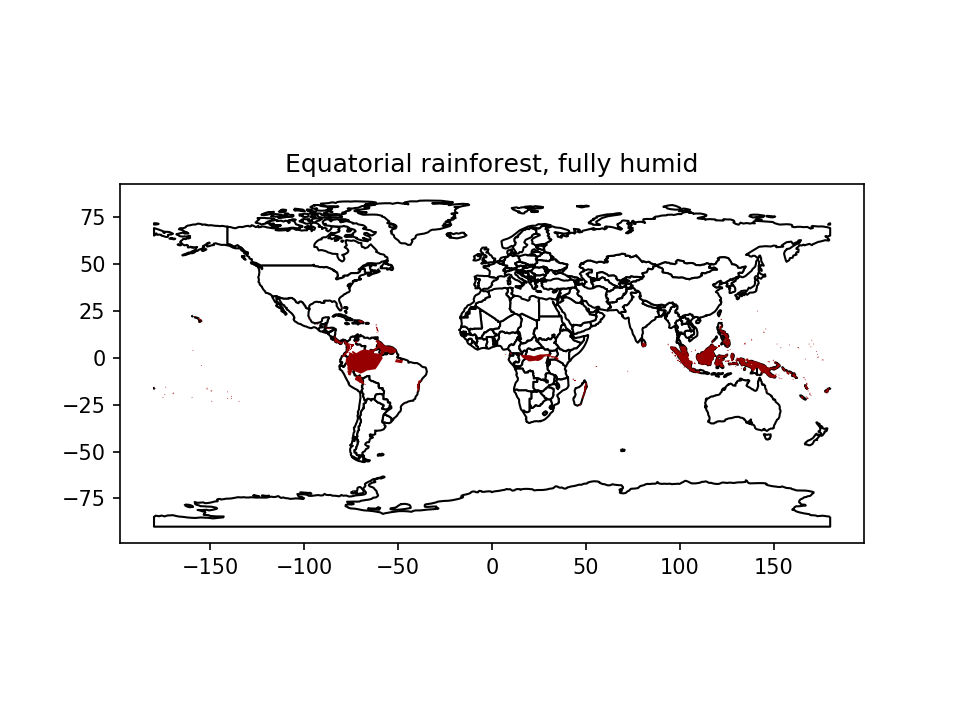

In [7]:
%matplotlib notebook

label=np.random.choice(np.unique(koppen_zones['LABEL']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
koppen_zones.loc[koppen_zones['LABEL']==label].plot(ax=ax, color=color_dict[label])
plt.title(info_zones.loc[info_zones['LABEL']==label,'LABEL_LONG'].values[0])
plt.show()

We print all climate zones, with 5 groups if `approximate=True`, 31 zones otherwise.

<IPython.core.display.Javascript object>


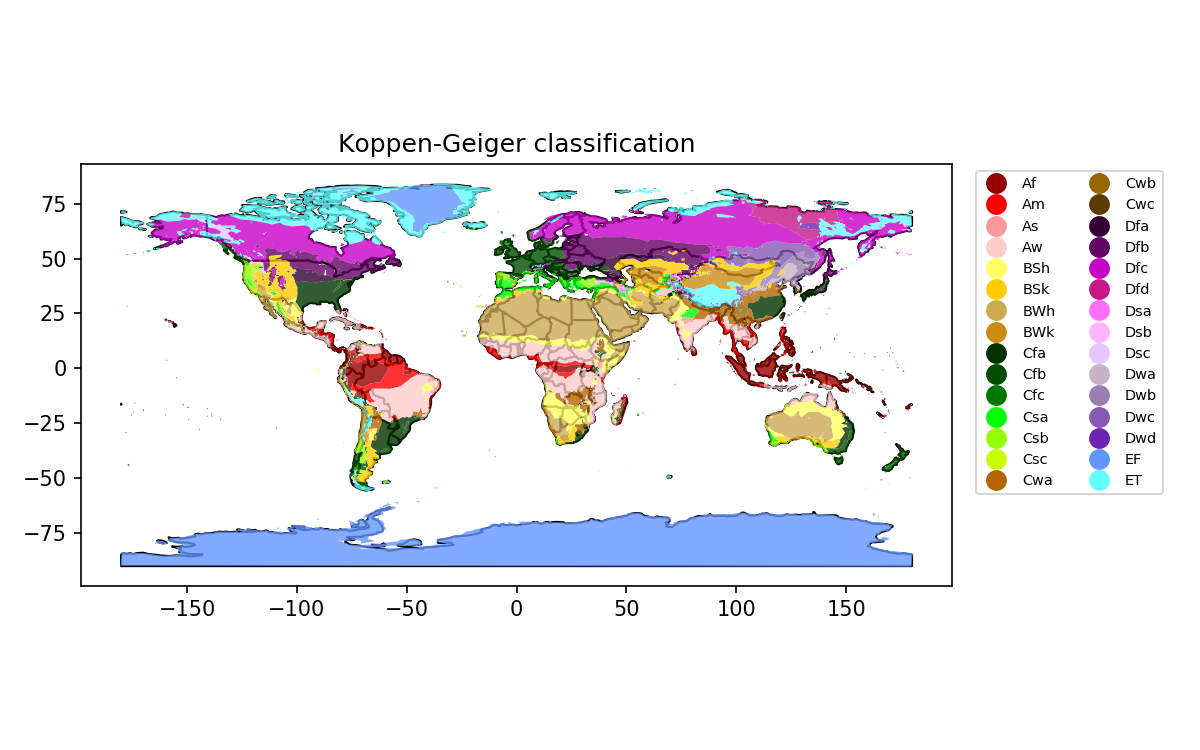

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
koppen_zones.plot(ax=ax, column='LABEL', categorical=True,
             legend=True, cmap=ListedColormap(color_array),
                 legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small',})
ax.set(title='Koppen-Geiger classification')
fig.tight_layout()
plt.show()

# Assign each basin to its climate zone

We upload basins data and set the longitude/latitude projection (`epsg=4326`).

In [10]:
basins=geopandas.read_file("../datasets/basins/basins.shp")
basins.set_index("CATCH_ID",inplace=True)
basins.crs = 'epsg:4326'
basins

,NAME,RASTAREA,DB_ID,SORTING,LATITUDE,geometry
CATCH_ID,,,,,,
1,KHATANGA,265580.70,3,71,69.00,"POLYGON ((107.98472 70.60880, 107.99635 70.602..."
2,COLVILLE RIVER,54793.19,8,180,69.00,"POLYGON ((-151.63553 68.05583, -151.56200 68.0..."
3,ODER RIVER,107297.80,103,114,51.75,"POLYGON ((17.77023 53.33484, 17.75817 53.27876..."
4,ELBE RIVER,134036.70,107,97,51.00,"POLYGON ((15.71059 50.73571, 15.80232 50.74939..."
5,TRENT,5591.48,106,256,53.00,"POLYGON ((-1.04140 52.50355, -1.07763 52.46482..."
...,...,...,...,...,...,...
405,URAL,194095.00,102,81,52.00,"POLYGON ((59.45863 54.73093, 59.45405 54.71379..."
406,WISLA,186147.40,104,83,51.50,"POLYGON ((23.27742 53.82209, 23.28833 53.78495..."
407,DON,378180.40,105,58,50.25,"POLYGON ((44.20445 47.83303, 44.16977 47.78534..."


For a given basin, we look at all the climate zones covering it.

<IPython.core.display.Javascript object>


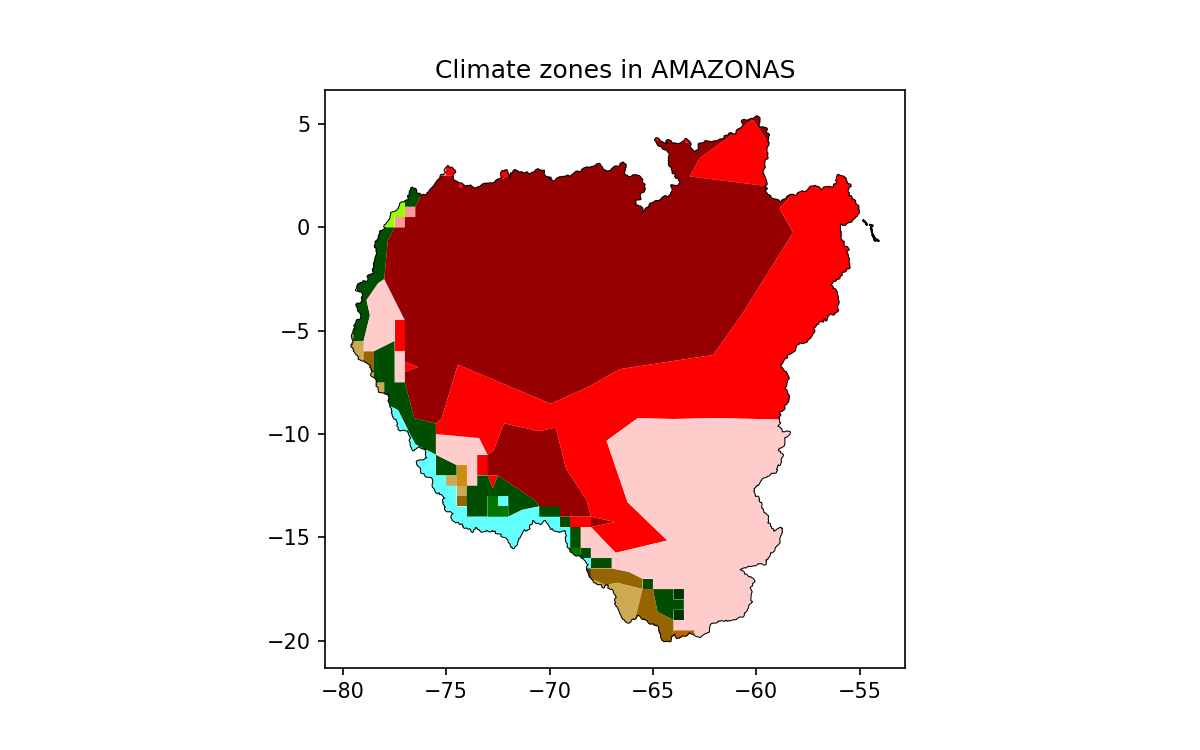

In [11]:
basin_name='AMAZONAS'

intersec=geopandas.overlay(koppen_zones, basins.loc[basins['NAME']==basin_name], how='intersection')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
basins.loc[basins['NAME']==basin_name].plot(ax=ax, color='white', edgecolor='black')
intersec.loc[intersec['NAME']==basin_name].plot(ax=ax,color=intersec['COLOR_HEX'])
plt.title("Climate zones in {}".format(basin_name))
plt.show()

For each basin, we compute the area of each climate zone and add the largest to the database.

In [12]:
# geometric intersection between climate zones and the basin
intersec=geopandas.overlay(koppen_zones[['geometry','LABEL','COLOR_HEX']], 
                           basins[['NAME','RASTAREA','geometry']], how='intersection')

# intersection creates multiple polygons that need to be assembled
intersec_meter=intersec.dissolve(by=['NAME','LABEL']).copy()

# projection to meters
intersec_meter=intersec_meter.to_crs('epsg:6933')

# area of the intersection (converted to km2)
intersec_meter['AREA']=intersec_meter['geometry'].area/1e6

# some areas are slightly larger than the one saved in the database, this is corrected
intersec_meter['AREA']=np.where(intersec_meter['AREA']>intersec_meter['RASTAREA'],intersec_meter['RASTAREA'],intersec_meter['AREA'])

# percentage area of each climate zone
intersec_meter['CLIMATE_AREA_%']=100*intersec_meter['AREA']/intersec_meter['RASTAREA']

# save labels in a separate column
intersec_meter['MAIN_CLIMATE']=intersec_meter.index.to_frame()['LABEL']

# keep labels with the largest area
intersec_meter.index=intersec_meter.index.droplevel(1)
intersec_max=intersec_meter.groupby('NAME')['CLIMATE_AREA_%'].max()
intersec_meter['largest area']=intersec_max
intersec_meter=intersec_meter.loc[intersec_meter['CLIMATE_AREA_%']==intersec_meter['largest area']]
intersec_meter.drop('largest area',axis=1,inplace=True)

# assign values
basins2=basins.join(intersec_meter[['MAIN_CLIMATE','CLIMATE_AREA_%','COLOR_HEX']],on='NAME')

We plot all river basins covered by a single climate zone over at least `threshold` percents. I don'k know how to map colors when some colors of the paletteare missing because the climate zone associated is not represented => need to use the color column.

<IPython.core.display.Javascript object>


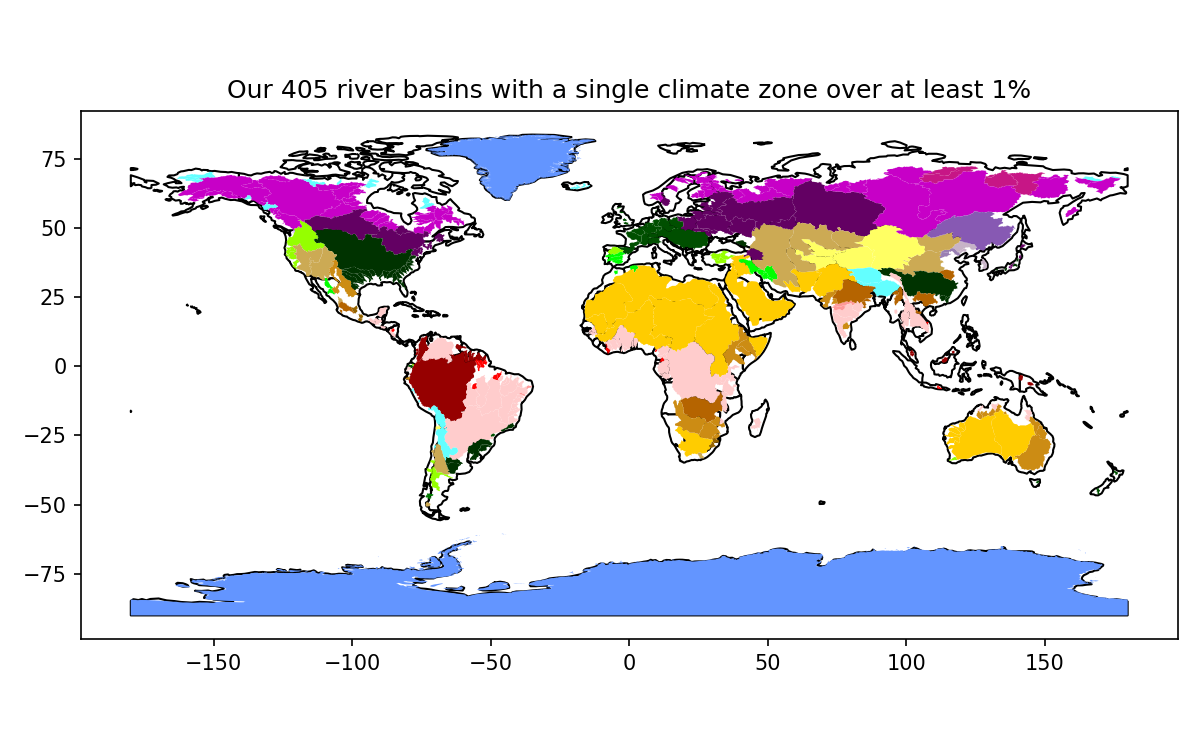

In [13]:
from matplotlib.colors import Normalize

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
threshold=1
selected_basins=basins2.loc[basins2['CLIMATE_AREA_%']>=threshold]

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
# this code works if all climate zones are represented in selected_basins
#selected_basins.plot(ax=ax, column='MAIN_CLIMATE', categorical=True,
#             legend=True, cmap=ListedColormap(color_array),norm=norm,
#            legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small'})

selected_basins.plot(ax=ax, color=selected_basins['COLOR_HEX'], categorical=True,
             legend=True,legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small'})
plt.title("Our {} river basins with a single climate zone over at least {}%".format(selected_basins.shape[0],threshold))
plt.tight_layout()
plt.show()

Number of basins in each climate zone

In [16]:
basins2.groupby('MAIN_CLIMATE').count()['NAME']

MAIN_CLIMATE
Af     16
Am     14
As      4
Aw     65
BSh    21
BSk    13
BWh    20
BWk     5
Cfa    37
Cfb    21
Cfc     2
Csa    11
Csb    17
Cwa    11
Cwb     5
Dfb    31
Dfc    72
Dfd     5
Dsc     1
Dwa     4
Dwb     2
Dwc     1
EF      2
ET     25
Name: NAME, dtype: int64

Save data

In [14]:
if approximate:
    basins2.to_file("../datasets/basins/basins_with_approx_climate_zones.shp")
else:
    basins2.to_file("../datasets/basins/basins_with_climate_zones.shp")